# Assignment 2 — Dataset Exploration

## Goal
Before preprocessing, we need to carefully explore the dataset structure:
- Check **all columns**: names, datatypes, missing values.
- Verify that the **target column** (`Recommended IND`) exists and is binary.
- Understand what extra columns we can use (Title, Age, Department, Division, etc.).
- Decide which columns should be treated as **categorical**, **numerical**, or **text**.

---

## Steps
1. **Load CSV** into a Pandas DataFrame.
2. **Inspect shape and columns**: how many rows, how many features.
3. **Check datatypes** (`df.dtypes`).
4. **Look for categorical-like columns**:
   - If dtype is `object` or `string`, treat as categorical/text.
   - If dtype is `int`/`float` but has small unique values (like `1,2,3`), convert to category.
5. **Check target distribution**: how many `0` vs `1` in `Recommended IND`.
6. **Preview a few rows** for sanity check.

In [1]:
import pandas as pd

# Path to CSV (adjust if needed)
DATA_CSV = "../data/assignment3_II.csv"

# Load
df = pd.read_csv(DATA_CSV)

# Shape & first look
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())

# Info
print("\nInfo:")
print(df.info())

# Target distribution
if "Recommended IND" in df.columns:
    print("\nTarget distribution:")
    print(df["Recommended IND"].value_counts(normalize=True))

# Peek at first rows
df.head(5)

Shape: (19662, 12)

Columns:
 ['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name', 'Clothes Title', 'Clothes Description']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19662 entries, 0 to 19661
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              19662 non-null  int64 
 1   Age                      19662 non-null  int64 
 2   Title                    19662 non-null  object
 3   Review Text              19662 non-null  object
 4   Rating                   19662 non-null  int64 
 5   Recommended IND          19662 non-null  int64 
 6   Positive Feedback Count  19662 non-null  int64 
 7   Division Name            19662 non-null  object
 8   Department Name          19662 non-null  object
 9   Class Name               19662 non-null  object
 10  Clothes Title       

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Clothes Title,Clothes Description
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Elegant A-Line Dress,"A classic A-line dress that flows gracefully, ..."
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,Petite High-Waisted Trousers,"Chic, high-waisted trousers designed to elonga..."
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Silk Button-Up Blouse,A luxurious silk blouse with a timeless button...
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses,Elegant A-Line Dress,"A classic A-line dress that flows gracefully, ..."
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits,Petite Cable Knit Sweater,A cozy cable knit sweater tailored specificall...


In [2]:
import pandas as pd

summary = []  # <-- must be a list, not a dict

for col in df.columns:
    unique_vals = df[col].dropna().unique()
    n_unique = len(unique_vals)

    # Decide column type
    if df[col].dtype in ["int64", "float64"]:
        if n_unique <= 10:
            col_type = "Categorical (numeric)"
        else:
            col_type = "Numerical"
    elif df[col].dtype == "object":
        if n_unique < 50:
            col_type = "Categorical"
        else:
            col_type = "Textual / High-cardinality"
    else:
        col_type = "Other"
    
    cats = list(unique_vals[:20]) if n_unique <= 30 else None  # only show if small
    summary.append({
        "Column": col,
        "Type": col_type,
        "Unique Count": n_unique,
        "Categories": cats
    })

summary_df = pd.DataFrame(summary)
display(summary_df)

,Column,Type,Unique Count,Categories
0,Clothing ID,Numerical,1095,None
1,Age,Numerical,77,None
2,Title,Textual / High-cardinality,13983,None
3,Review Text,Textual / High-cardinality,19656,None
4,Rating,Categorical (numeric),5,"[3, 5, 2, 4, 1]"
5,Recommended IND,Categorical (numeric),2,"[0, 1]"
6,Positive Feedback Count,Numerical,79,None
7,Division Name,Categorical,3,"[General, General Petite, Initmates]"
8,Department Name,Categorical,6,"[Dresses, Bottoms, Tops, Intimate, Jackets, Tr..."
9,Class Name,Categorical,20,"[Dresses, Pants, Blouses, Knits, Intimates, Ou..."


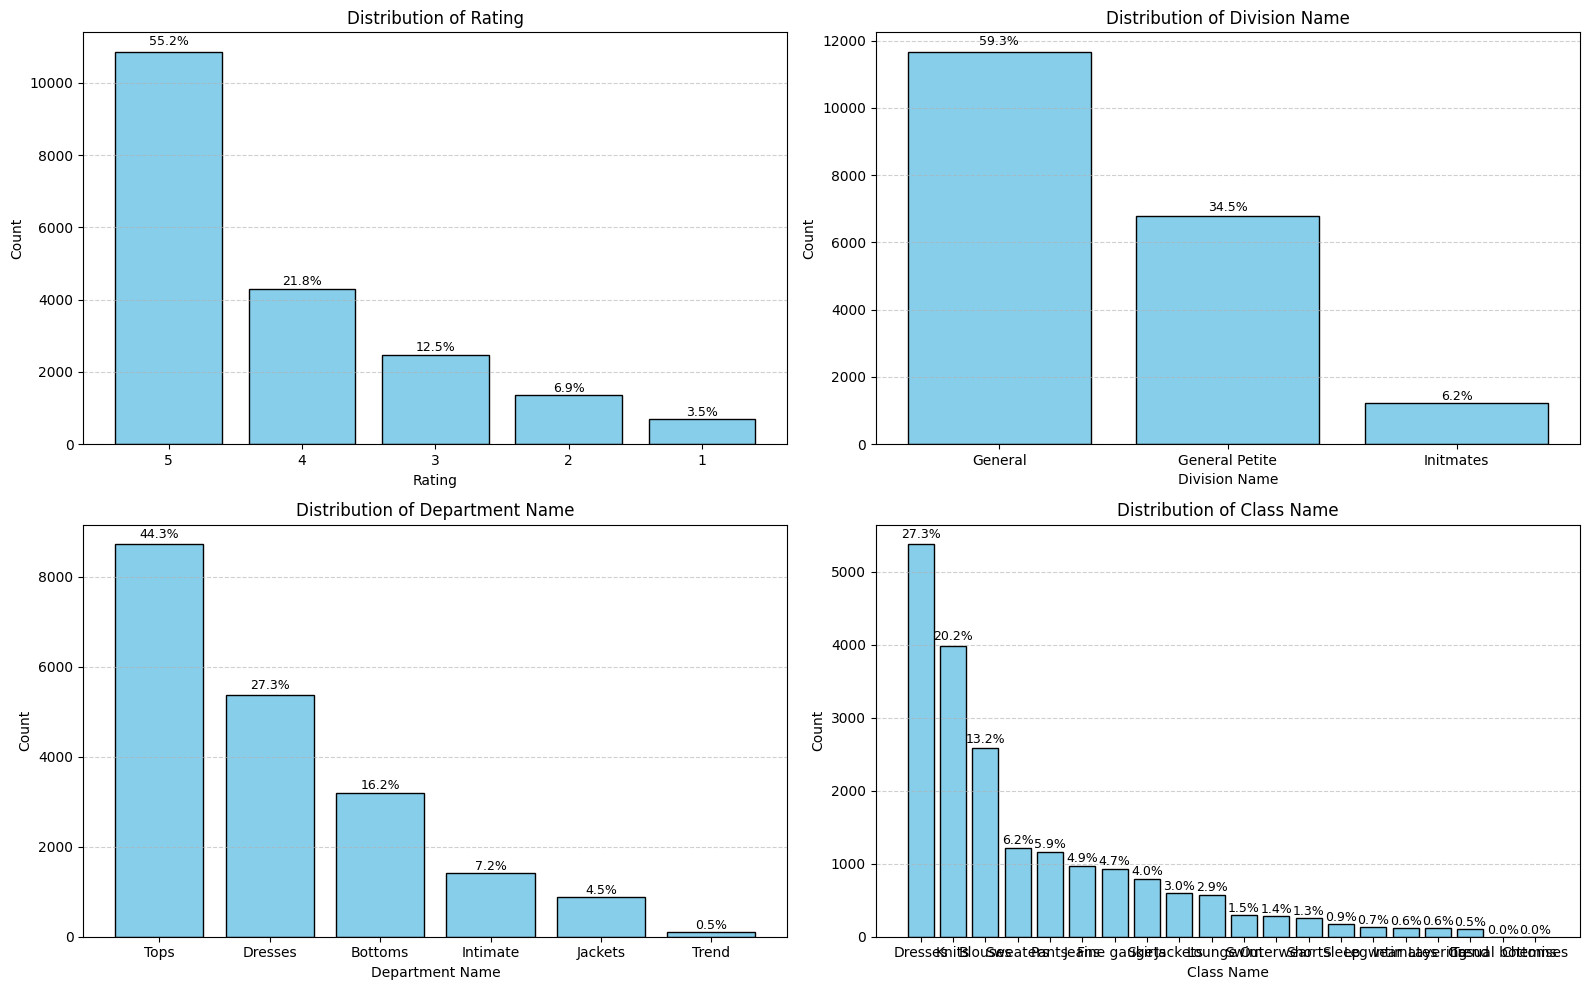

In [3]:
import matplotlib.pyplot as plt

# Categorical columns to plot
cat_cols = ["Rating", "Division Name", "Department Name", "Class Name"]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    counts = df[col].value_counts()
    percentages = counts / counts.sum() * 100
    
    bars = axes[i].bar(
        counts.index.astype(str),
        counts.values,
        color="skyblue",
        edgecolor="black"
    )
    
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel(col)
    axes[i].grid(axis="y", linestyle="--", alpha=0.6)
    
    # Add percentage labels above each bar
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,
            height + (height * 0.01),   # slight offset above bar
            f"{pct:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9,
            color="black"
        )

plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Define categorical columns of interest
cat_cols = ["Rating", "Division Name", "Department Name", "Class Name"]

# Build summary table
summary_list = []
for col in cat_cols:
    counts = df[col].value_counts()
    percentages = counts / counts.sum() * 100
    for category, count in counts.items():
        summary_list.append({
            "Column": col,
            "Category": category,
            "Count": count,
            "Percentage": f"{percentages[category]:.1f}%"
        })

summary_table = pd.DataFrame(summary_list)

# Display summary table
print("=== Summary Table of Categories ===")
display(summary_table)

=== Summary Table of Categories ===


,Column,Category,Count,Percentage
0,Rating,5,10858,55.2%
1,Rating,4,4289,21.8%
2,Rating,3,2464,12.5%
3,Rating,2,1360,6.9%
4,Rating,1,691,3.5%
5,Division Name,General,11664,59.3%
6,Division Name,General Petite,6778,34.5%
7,Division Name,Initmates,1220,6.2%
8,Department Name,Tops,8713,44.3%
9,Department Name,Dresses,5371,27.3%


In [5]:
# scripts/build_json.py
import json
from pathlib import Path
import pandas as pd
NB_DIR = Path.cwd().resolve()
CANDIDATES = [
    NB_DIR / "data" / "assignment3_II.csv",
    NB_DIR.parent / "data" / "assignment3_II.csv",
    NB_DIR.parents[1] / "data" / "assignment3_II.csv",
]
DATA_CSV = next((p for p in CANDIDATES if p.exists()), None)
if DATA_CSV is None:
    raise FileNotFoundError("Place 'assignment3_II.csv' under project_root/data/")


PROJECT_ROOT = DATA_CSV.parent.parent
DATA = PROJECT_ROOT / "data"
CSV  = PROJECT_ROOT / "data/assignment3_II.csv"

CATALOG = DATA / "site_items.json"
REVIEWS = DATA / "site_reviews.json"

df = pd.read_csv(CSV)

# --- Clean basics ---
for c in ["Clothes Title","Clothes Description","Division Name","Department Name","Class Name","Title","Review Text"]:
    if c in df.columns:
        df[c] = df[c].fillna("")

if "Rating" in df.columns:
    df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce").fillna(0)

# --- Catalog (one row per Clothing ID) ---
agg = (
    df.groupby("Clothing ID", as_index=False)
      .agg({
          "Clothes Title": "first",
          "Clothes Description": "first",
          "Division Name": "first",
          "Department Name": "first",
          "Class Name": "first",
          "Rating": "mean",
          "Review Text": "count",
      })
      .rename(columns={
          "Rating": "avg_rating",
          "Review Text": "review_count",
      })
)

catalog = []
for _, r in agg.iterrows():
    catalog.append({
        "id": int(r["Clothing ID"]),
        "clothes_title": r["Clothes Title"] or r.get("Title",""),
        "clothes_desc": r["Clothes Description"],
        "division": r["Division Name"],
        "department": r["Department Name"],
        "class": r["Class Name"],
        "avg_rating": float(r["avg_rating"]),
        "review_count": int(r["review_count"]),
        # short preview for cards
        "preview": (r["Clothes Description"] or "")[:180]
    })

CATALOG.write_text(json.dumps(catalog, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"wrote {CATALOG} — items: {len(catalog)}")

# --- Reviews (many rows per Clothing ID) ---
reviews = []
cols = {
    "Clothing ID":"id",
    "Age":"age",
    "Title":"title",
    "Review Text":"review_text",
    "Rating":"rating",
    "Recommended IND":"recommended",
    "Positive Feedback Count":"positive_feedback",
    "Division Name":"division",
    "Department Name":"department",
    "Class Name":"class",
}
for _, r in df.iterrows():
    item = {}
    for src, dst in cols.items():
        item[dst] = r.get(src, "")
    # coerce numerics
    for k in ("id","age","rating","recommended","positive_feedback"):
        try: item[k] = int(item[k])
        except: item[k] = 0
    reviews.append(item)

REVIEWS.write_text(json.dumps(reviews, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"wrote {REVIEWS} — rows: {len(reviews)}")

wrote /Users/mac/Desktop/dem-web/data/site_items.json — items: 1095
wrote /Users/mac/Desktop/dem-web/data/site_reviews.json — rows: 19662


In [6]:
# Notebook cell: imports & paths
import sqlite3
from pathlib import Path
import pandas as pd
import numpy as np

# Project paths (adjust if your notebook sits outside the repo root)
PROJECT_ROOT = Path.cwd().resolve()
DATA_DIR     = PROJECT_ROOT / "data"
DATA_DIR.mkdir(parents=True, exist_ok=True)

CSV_PATH = DATA_DIR / "assignment3_II.csv"   # <- your CSV
DB_PATH  = DATA_DIR / "app.db"               # <- target SQLite DB

print("CSV :", CSV_PATH)
print("DB  :", DB_PATH)

CSV : /Users/mac/Desktop/dem-web/notebooks/data/assignment3_II.csv
DB  : /Users/mac/Desktop/dem-web/notebooks/data/app.db


In [7]:
from pathlib import Path

# Notebook base dir
NB_DIR = Path.cwd().resolve()

# Candidate locations for the CSV
CANDIDATES = [
    NB_DIR / "data" / "assignment3_II.csv",
    NB_DIR.parent / "data" / "assignment3_II.csv",
    NB_DIR.parents[1] / "data" / "assignment3_II.csv",
]

# Pick the first existing CSV
DATA_CSV = next((p for p in CANDIDATES if p.exists()), None)
if DATA_CSV is None:
    raise FileNotFoundError("❌ Could not find 'assignment3_II.csv'. Place it under project_root/data/")

# Project root is always the parent of /data
PROJECT_ROOT = DATA_CSV.parent.parent

# Standardized paths
CSV_PATH = PROJECT_ROOT / "data" / "assignment3_II.csv"
DB_PATH  = PROJECT_ROOT / "data" / "app.db"

print("📄 CSV found at :", CSV_PATH)
print("🗄️  SQLite DB   :", DB_PATH)
print("📂 Project root :", PROJECT_ROOT)

📄 CSV found at : /Users/mac/Desktop/dem-web/data/assignment3_II.csv
🗄️  SQLite DB   : /Users/mac/Desktop/dem-web/data/app.db
📂 Project root : /Users/mac/Desktop/dem-web


In [8]:
# Notebook cell: load CSV and normalize columns
if not CSV_PATH.exists():
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}")

df = pd.read_csv(CSV_PATH)

# Ensure columns exist (fallbacks if dataset uses slightly different names)
expected_cols = [
    "Clothing ID","Age","Title","Review Text","Rating",
    "Recommended IND","Positive Feedback Count",
    "Division Name","Department Name","Class Name","Clothes Description"
]
for c in expected_cols:
    if c not in df.columns:
        df[c] = np.nan  # create missing columns if necessary

# Fill strings safely and coerce numerics
def as_int(x, default=0):
    try:
        return int(x)
    except Exception:
        return default

df["Clothing ID"] = df["Clothing ID"].apply(as_int)
df["Age"] = df["Age"].apply(as_int)
df["Rating"] = df["Rating"].apply(as_int)
df["Recommended IND"] = df["Recommended IND"].apply(as_int)
df["Positive Feedback Count"] = df["Positive Feedback Count"].apply(as_int)

for col in ["Title","Review Text","Division Name","Department Name","Class Name","Clothes Description"]:
    df[col] = df[col].fillna("").astype(str).str.strip()

# Drop garbage rows with missing Clothing ID
df = df[df["Clothing ID"] > 0].copy()

print("Rows:", len(df))
df.head(3)

Rows: 19662


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Clothes Title,Clothes Description
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Elegant A-Line Dress,"A classic A-line dress that flows gracefully, ..."
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,Petite High-Waisted Trousers,"Chic, high-waisted trousers designed to elonga..."
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Silk Button-Up Blouse,A luxurious silk blouse with a timeless button...


In [9]:
# Notebook cell: build items (deduplicate by Clothing ID)
# Pick the first non-empty description for each Clothing ID, otherwise fallback to the first review text.

def first_non_empty(series: pd.Series, fallback: str = "") -> str:
    for v in series:
        if isinstance(v, str) and v.strip():
            return v.strip()
    return fallback

agg_items = (
    df.groupby("Clothing ID")
      .agg({
          "Division Name": "first",
          "Department Name": "first",
          "Class Name": "first",
          "Clothes Description": lambda s: first_non_empty(s, ""),
          "Review Text": lambda s: first_non_empty(s, "")
      })
      .reset_index()
)

# If Clothes Description is empty, use Review Text as a short description
mask_empty = (agg_items["Clothes Description"].str.len() == 0)
agg_items.loc[mask_empty, "Clothes Description"] = agg_items.loc[mask_empty, "Review Text"].str.slice(0, 300)

items_df = agg_items.rename(columns={
    "Clothing ID": "clothing_id",
    "Division Name": "division",
    "Department Name": "department",
    "Class Name": "class",
    "Clothes Description": "description"
})[["clothing_id","division","department","class","description"]]

print("Items (unique Clothing ID):", len(items_df))
items_df.head(3)

Items (unique Clothing ID): 1095


,clothing_id,division,department,class,description
0,1,Initmates,Intimate,Layering,A seamless bodysuit perfect for layering. Comf...
1,2,General,Tops,Knits,A versatile ribbed knit top that pairs well wi...
2,4,General,Tops,Sweaters,A luxurious cashmere turtleneck that combines ...


In [10]:
# Notebook cell: build reviews dataframe (every row is a review)
reviews_df = pd.DataFrame({
    "clothing_id": df["Clothing ID"].apply(as_int),
    "age": df["Age"].apply(as_int),
    "title": df["Title"].fillna("").astype(str).str.strip(),
    "review_text": df["Review Text"].fillna("").astype(str).str.strip(),
    "rating": df["Rating"].apply(as_int),
    "recommended": df["Recommended IND"].apply(lambda x: 1 if as_int(x) == 1 else 0),
    "positive_feedback": df["Positive Feedback Count"].apply(as_int)
})

# Keep only rows with text & valid rating (simple guard)
reviews_df = reviews_df[(reviews_df["review_text"].str.len() > 0) & (reviews_df["rating"].between(1,5))]
print("Reviews:", len(reviews_df))
reviews_df.head(3)

Reviews: 19662


,clothing_id,age,title,review_text,rating,recommended,positive_feedback
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6


In [11]:
# ==== Milestone II: Build SQLite DB from CSV (1 cell, copy/paste) ====
import sqlite3
from pathlib import Path
import pandas as pd
import numpy as np

# ---------------------------
# 1) Locate project paths
# ---------------------------
NB_DIR = Path.cwd().resolve()
CANDIDATES = [
    NB_DIR / "data" / "assignment3_II.csv",
    NB_DIR.parent / "data" / "assignment3_II.csv",
    NB_DIR.parents[1] / "data" / "assignment3_II.csv",
]
DATA_CSV = next((p for p in CANDIDATES if p.exists()), None)
if DATA_CSV is None:
    raise FileNotFoundError("Place 'assignment3_II.csv' under project_root/data/")

PROJECT_ROOT = DATA_CSV.parent.parent
DB_PATH = PROJECT_ROOT / "data" / "app.db"
CSV_PATH = DATA_CSV

print("CSV :", CSV_PATH)
print("DB  :", DB_PATH)

# ---------------------------
# 2) Load CSV (robustly)
# ---------------------------
df = pd.read_csv(CSV_PATH)

# Normalize column names we rely on
need = {
    "Clothing ID": "Clothing ID",
    "Age": "Age",
    "Title": "Title",
    "Review Text": "Review Text",
    "Rating": "Rating",
    "Recommended IND": "Recommended IND",
    "Positive Feedback Count": "Positive Feedback Count",
    "Division Name": "Division Name",
    "Department Name": "Department Name",
    "Class Name": "Class Name",
    "Clothes Title": "Clothes Title",
    "Clothes Description": "Clothes Description",
}
for k, v in need.items():
    if k not in df.columns:
        # Create missing with safe defaults
        if k in ("Age", "Rating", "Recommended IND", "Positive Feedback Count"):
            df[k] = 0
        else:
            df[k] = ""

# Clean types
def to_int_safe(x, default=0):
    try:
        v = int(float(x))
        return v
    except Exception:
        return default

for c in ("Clothing ID", "Age", "Rating", "Recommended IND", "Positive Feedback Count"):
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

for c in (
    "Title",
    "Review Text",
    "Division Name",
    "Department Name",
    "Class Name",
    "Clothes Title",
    "Clothes Description",
):
    df[c] = df[c].fillna("").astype(str)

# ---------------------------
# ---------------------------
# 3) Build items_df (one row per Clothing ID) — robust sorting
# ---------------------------
def first_non_empty(series: pd.Series) -> str:
    for v in series:
        if isinstance(v, str) and v.strip():
            return v.strip()
    return ""

# Add a helper column for review-text length, then sort by names only
df["__rt_len"] = df["Review Text"].fillna("").astype(str).str.len()

rep = (
    df.sort_values(["Clothing ID", "__rt_len"], ascending=[True, False])
      .drop_duplicates(subset=["Clothing ID"], keep="first")
      .drop(columns="__rt_len")
)

# Prefer Clothes Title -> fallback Title
title_pref     = rep["Clothes Title"].str.strip()
title_fallback = rep["Title"].str.strip()
clothes_title  = np.where(title_pref != "", title_pref, title_fallback)

# Prefer Clothes Description -> fallback first 200 chars of Review Text
desc_pref      = rep["Clothes Description"].str.strip()
desc_fallback  = rep["Review Text"].fillna("").astype(str).str.strip().str.slice(0, 200)
description    = np.where(desc_pref != "", desc_pref, desc_fallback)

# Aggregate meta per clothing_id
grouped = df.groupby("Clothing ID", as_index=False).agg({
    "Division Name": first_non_empty,
    "Department Name": first_non_empty,
    "Class Name": first_non_empty,
})

# Merge meta + chosen title/desc
items_df = grouped.merge(
    rep[["Clothing ID"]].assign(
        clothes_title=clothes_title,
        description=description
    ),
    on="Clothing ID",
    how="left"
)

items_df.rename(columns={
    "Clothing ID": "clothing_id",
    "Division Name": "division",
    "Department Name": "department",
    "Class Name": "class_name",
}, inplace=True)

# Type & NA safety
items_df["clothing_id"] = items_df["clothing_id"].apply(lambda x: int(float(x)) if pd.notna(x) else 0)
for c in ("division", "department", "class_name", "clothes_title", "description"):
    items_df[c] = items_df[c].fillna("").astype(str)

# ---------------------------
# 4) Build reviews_df (all rows)
# ---------------------------
reviews_df = df[[
    "Clothing ID", "Age", "Title", "Review Text", "Rating", "Recommended IND", "Positive Feedback Count"
]].copy()

reviews_df.rename(columns={
    "Clothing ID": "clothing_id",
    "Age": "age",
    "Title": "title",
    "Review Text": "review_text",
    "Rating": "rating",
    "Recommended IND": "recommended",
    "Positive Feedback Count": "positive_feedback",
}, inplace=True)

# Type safety
reviews_df["clothing_id"] = reviews_df["clothing_id"].apply(to_int_safe)
reviews_df["age"] = reviews_df["age"].apply(to_int_safe)
reviews_df["rating"] = reviews_df["rating"].apply(to_int_safe)
reviews_df["recommended"] = reviews_df["recommended"].apply(lambda x: 1 if to_int_safe(x) == 1 else 0)
reviews_df["positive_feedback"] = reviews_df["positive_feedback"].apply(to_int_safe)
for c in ("title", "review_text"):
    reviews_df[c] = reviews_df[c].fillna("").astype(str)

# Drop reviews that have no valid clothing_id
reviews_df = reviews_df[reviews_df["clothing_id"] > 0].copy()

print("items_df:", items_df.shape, "| reviews_df:", reviews_df.shape)

# ---------------------------
# 5) Recreate schema (idempotent)
# ---------------------------
DB_PATH.parent.mkdir(parents=True, exist_ok=True)
con = sqlite3.connect(DB_PATH)
cur = con.cursor()
cur.execute("PRAGMA foreign_keys = ON;")

cur.executescript("""
DROP TABLE IF EXISTS reviews;
DROP TABLE IF EXISTS items;

CREATE TABLE items (
    clothing_id   INTEGER PRIMARY KEY,
    clothes_title TEXT,
    description   TEXT,
    division      TEXT,
    department    TEXT,
    class_name    TEXT
);

CREATE TABLE reviews (
    id                INTEGER PRIMARY KEY AUTOINCREMENT,
    clothing_id       INTEGER NOT NULL,
    age               INTEGER,
    title             TEXT,
    review_text       TEXT,
    rating            INTEGER,
    recommended       INTEGER,
    positive_feedback INTEGER,
    FOREIGN KEY (clothing_id) REFERENCES items (clothing_id) ON DELETE CASCADE
);
""")
con.commit()

# ---------------------------
# 6) Bulk insert
# ---------------------------
# Convert to vanilla tuples (avoid NumPy dtypes)
items_tuples = [
    (
        int(row.clothing_id),
        str(row.clothes_title),
        str(row.description),
        str(row.division),
        str(row.department),
        str(row.class_name),
    )
    for row in items_df.itertuples(index=False)
]

reviews_tuples = [
    (
        int(row.clothing_id),
        int(row.age),
        str(row.title),
        str(row.review_text),
        int(row.rating),
        int(row.recommended),
        int(row.positive_feedback),
    )
    for row in reviews_df.itertuples(index=False)
]

cur.executemany("""
    INSERT OR REPLACE INTO items
        (clothing_id, clothes_title, description, division, department, class_name)
    VALUES (?, ?, ?, ?, ?, ?)
""", items_tuples)

cur.executemany("""
    INSERT INTO reviews
        (clothing_id, age, title, review_text, rating, recommended, positive_feedback)
    VALUES (?, ?, ?, ?, ?, ?, ?)
""", reviews_tuples)

con.commit()

# ---------------------------
# 7) Sanity checks
# ---------------------------
n_items = cur.execute("SELECT COUNT(*) FROM items").fetchone()[0]
n_reviews = cur.execute("SELECT COUNT(*) FROM reviews").fetchone()[0]
ex = cur.execute("""
    SELECT i.clothing_id, i.clothes_title, i.division, i.department, i.class_name,
           COUNT(r.id) AS review_count,
           ROUND(AVG(CASE WHEN r.rating BETWEEN 1 AND 5 THEN r.rating END),2) AS avg_rating
    FROM items i
    LEFT JOIN reviews r ON r.clothing_id = i.clothing_id
    GROUP BY i.clothing_id
    ORDER BY review_count DESC
    LIMIT 3
""").fetchall()

con.close()

print(f"✅ Inserted {n_items} items and {n_reviews} reviews.")
print("Top 3 items by review_count (id, title, division, department, class, review_count, avg_rating):")
for row in ex:
    print("  ", row)

CSV : /Users/mac/Desktop/dem-web/data/assignment3_II.csv
DB  : /Users/mac/Desktop/dem-web/data/app.db
items_df: (1095, 6) | reviews_df: (19662, 7)
✅ Inserted 1095 items and 19662 reviews.
Top 3 items by review_count (id, title, division, department, class, review_count, avg_rating):
   (1078, 'Elegant A-Line Dress', 'General Petite', 'Dresses', 'Dresses', 871, 4.18)
   (862, 'Classic Ribbed Knit Top', 'General', 'Tops', 'Knits', 658, 4.19)
   (1094, 'Elegant A-Line Dress', 'General Petite', 'Dresses', 'Dresses', 651, 4.18)


In [13]:
pip install dill

  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
Using cached dill-0.4.0-py3-none-any.whl (119 kB)
Note: you may need to restart the kernel to use updated packages.
